In [1]:
import pandas as pd
import numpy as np
# import lightgbm as lgb
import xgboost as xgb
# import catboost as cat
import datetime
import warnings
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import sklearn
import gc

C:\Users\Gearup\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',1000)

#https://blog.csdn.net/u010665216/article/details/80556000

KalmanFilter:是一种信息融合的过程，是将过去的测量估计误差合并到新的测量误差中来估计将来的误差。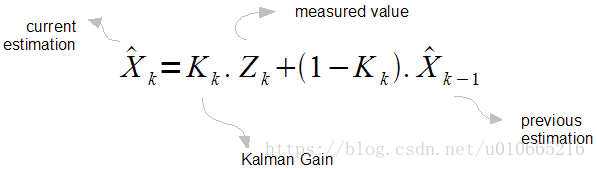

Kk 指卡尔曼增益（这是整个公式中的核心点），找到对应于每个状态的更加智能化的卡尔曼增益系数。归根结底就是：卡尔曼滤波器为每个结果状态找到最优的平均因子

In [3]:
def kalman_smooth(x):
    series = [x['sales_0'], x['sales_1'], x['sales_2'], x['sales_3'], x['sales_4'],
                      x['sales_5'], x['sales_6'], x['sales_7'], x['sales_8'], x['sales_9'], x['sales_10'], x['sales_11'],
                      x['sales_12'], x['sales_13'], x['sales_14']]
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=1, initial_state_mean=series[0])
    state_means, state_covariance = kf.smooth(series)
    return state_means.ravel().tolist()#返回array值转换成list结构

# 测试、查看业务数据代码

In [5]:
    df = pd.read_csv('./goodsale_modified1.csv')
    #df = pd.read_csv('./goodsale.csv')
    df['data_date'] = pd.to_datetime(df['data_date'], format='%Y-%m-%d')
    sub = pd.read_csv('./submit_example_2.csv')
    info = pd.read_csv('./goodsinfo.csv')
    relation = pd.read_csv('./goods_sku_relation.csv')
    relation = pd.merge(relation, info, on='goods_id')#商品的属性信息与商品sku映射表关联
    
    df['goods_price'] = df['goods_price'].map(lambda x: x.replace(',', '') if type(x) == np.str else x)#文本转换，替换掉‘,’。
    df['goods_price'] = pd.to_numeric(df['goods_price'])#转化数据为数字型
    df['orginal_shop_price'] = df['orginal_shop_price'].map(lambda x: x.replace(',', '') if type(x) == np.str else x)#文本转换，替换掉‘,’。
    df['orginal_shop_price'] = pd.to_numeric(df['orginal_shop_price'])#转化数据为数字型
    
    daily = pd.read_csv('./daily_modified1.csv')#数据daily_modified1为处理过生成数据
    daily['data_date'] = pd.to_datetime(daily['data_date'], format='%Y-%m-%d')#转换日期格式为年月日，原始格式为如20171103。
    droped = daily.drop_duplicates(subset='goods_id')#相同goods_id的数据中，一行元素全部相同时才去除。
    droped['open_date'] = droped.apply(lambda x: x['data_date'] - datetime.timedelta(x['onsale_days']), axis=1)#新增列“open_date”，商家距离销售日的天数
    
    grouped = df.groupby(['sku_id', 'own_week'])['goods_num'].sum().reset_index()#对商品销售数据商品id、销售时间距离当前时间相差的周数进行透视，计算销售数量
    pivot = grouped.pivot(index='sku_id', columns='own_week', values='goods_num')
    new_columns = {}
    for i in list(pivot.columns):
        new_columns[i] = 'sales_' + str(i)#根据周数，转置成每周columns【i】字段，空值填充0.
    pivot.rename(columns=new_columns, inplace=True)
    pivot.fillna(0, inplace=True)
    
    grouped_daily = daily.groupby(['goods_id', 'own_week'])['goods_click'].sum().reset_index()#对商品id、相差的周数进行透视，计算商品点击数量
    pivot_daily = grouped_daily.pivot(index='goods_id', columns='own_week', values='goods_click')
    new_columns = {}
    for i in list(pivot_daily.columns):
        new_columns[i] = 'goods_click_' + str(i)#根据商品点击次数，转置成每周columns【i】字段，空值填充0.
    pivot_daily.rename(columns=new_columns, inplace=True)
    pivot_daily.fillna(0, inplace=True)
    
    grouped_daily_cart = daily.groupby(['goods_id', 'own_week'])['cart_click'].sum().reset_index()#对商品id、相差的周数进行透视，计算商品加购次数
    pivot_daily_cart = grouped_daily_cart.pivot(index='goods_id', columns='own_week', values='cart_click')
    new_columns = {}
    for i in list(pivot_daily_cart.columns):
        new_columns[i] = 'cart_click_' + str(i)#根据商品加购次数，转置成每周columns【i】字段，空值填充0.
    pivot_daily_cart.rename(columns=new_columns, inplace=True)
    pivot_daily_cart.fillna(0, inplace=True)
    
    grouped_daily_fav = daily.groupby(['goods_id', 'own_week'])['favorites_click'].sum().reset_index()#对商品id、相差的周数进行透视，计算商品收藏次数
    pivot_daily_fav = grouped_daily_fav.pivot(index='goods_id', columns='own_week', values='favorites_click')
    new_columns = {}
    for i in list(pivot_daily_fav.columns):
        new_columns[i] = 'favorites_click_' + str(i)#根据商品收藏次数，转置成每周columns【i】字段，空值填充0.
    pivot_daily_fav.rename(columns=new_columns, inplace=True)
    pivot_daily_fav.fillna(0, inplace=True)
    
    grouped_daily_uv = daily.groupby(['goods_id', 'own_week'])['sales_uv'].sum().reset_index()#对商品id、相差的周数进行透视，计算商品购买人数
    pivot_daily_uv = grouped_daily_uv.pivot(index='goods_id', columns='own_week', values='sales_uv')
    new_columns = {}
    for i in list(pivot_daily_uv.columns):
        new_columns[i] = 'sales_uv_' + str(i)#根据商品购买人数，转置成每周columns【i】字段，空值填充0.
    pivot_daily_uv.rename(columns=new_columns, inplace=True)
    pivot_daily_uv.fillna(0, inplace=True)
    
    sub = pd.merge(sub, pivot, on='sku_id', how='left')#合并商品销售数量和5月1日起后五周的数据
    sub = pd.merge(sub, relation, on='sku_id', how='left')#合并关系对应表
    sub = pd.merge(sub, pivot_daily, on='goods_id', how='left')#合并商品点击数据
    sub = pd.merge(sub, pivot_daily_cart, on='goods_id', how='left')#合并商品加购数据
    sub = pd.merge(sub, pivot_daily_fav, on='goods_id', how='left')#合并商品收藏次数数据
    sub = pd.merge(sub, pivot_daily_uv, on='goods_id', how='left')#合并购买人数数据
    
    sub = pd.merge(sub, droped[['goods_id', 'open_date']], on='goods_id', how='left')#droped去重后的用户表现行为数据合并sub
    sub['onsale_train'] = sub['open_date'].map(lambda x: (datetime.datetime(2018, 3, 16) - x).days)
    sub['onsale_test'] = sub['open_date'].map(lambda x: (datetime.datetime(2018, 5, 7) - x).days)
    sub['concat'] = sub.apply(lambda x: str(x['cat_level1_id']) +
                                        '_' + str(x['cat_level2_id']) + '_' + str(x['cat_level3_id'])
                                        + '_' + str(x['cat_level4_id']) + '_' + str(x['cat_level5_id']), axis=1)
    
    raw_price = df.groupby('sku_id')['orginal_shop_price'].mean().reset_index()#计算商品原始吊牌价格的平均值。多个sku_id透视求平均
    real_price = df.groupby('sku_id')['goods_price'].mean().reset_index()#计算商品销售价格的平均值。多个sku_id透视求平均
    
    sub = pd.merge(sub, raw_price, on='sku_id', how='left')
    sub = pd.merge(sub, real_price, on='sku_id', how='left')
    
    sub['discount'] = sub['orginal_shop_price'] - sub['goods_price']#折扣价格差

C:\Users\Gearup\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Gearup\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#计算sales_0`14每个值平滑预测后的结果

In [6]:
    sub['smooth'] = sub.apply(lambda x: kalman_smooth(x), axis=1)
    for i in range(15):
        sub['sales_smo_'+str(i)] = sub.apply(lambda x: x['smooth'][i], axis=1)

In [38]:
df.head()

,data_date,goods_id,sku_id,goods_num,goods_price,orginal_shop_price,own_week
0,2017-05-18,GIxOHa,SKg8D0d7,1,1.99,1.99,43
1,2017-11-30,GrXpTc,SKq3pF8j,6,29.99,37.99,15
2,2017-10-19,G3ORTV,SKIwiWXl,1,6.99,11.99,21
3,2017-05-31,GDRp2b,SKRNl1oL,1,16.99,21.99,41
4,2017-06-10,GHulZo,SKtD5qKW,1,5.99,5.99,39


In [26]:
sub['sales_smo_2']#

0          0.724465
1          9.552215
2          0.167184
3          0.136301
4          0.953618
5          0.244161
6          0.121564
7          0.176715
8          0.266421
9          0.193420
10         2.852127
11         0.113007
12         0.111456
13         0.111456
14         1.783299
15         1.929910
16         0.220499
17         2.433242
18         0.501761
19         0.836926
20        11.584234
21         1.292452
22         0.111456
23         0.111456
24         0.724465
25         0.524992
26         0.112918
27         0.446009
28         2.560560
29         1.287654
30         0.730393
31         0.170916
32         0.167315
33         0.445825
34         0.328330
35         0.111456
36         0.115283
37         0.120946
38         0.176501
39         0.682392
40         0.402519
41         0.115158
42         0.429343
43         0.904667
44         0.445825
45         1.582521
46         2.058982
47         1.819627
48         0.222912
49         4.696861


In [7]:
info.head(2)

,goods_id,cat_level1_id,cat_level2_id,cat_level3_id,cat_level4_id,cat_level5_id,cat_level6_id,cat_level7_id,goods_season,brand_id
0,GBLrYn,2,6,-1,-1,-1,-1,-1,0,0
1,GKq3V9,2,6,-1,-1,-1,-1,-1,0,0


#根据销售周数距离远近，分别乘上不同权重的值，距离越远，权重值越小。

In [10]:
    sub['sales_8'] = sub['sales_8'] * 1.1
    sub['sales_9'] = sub['sales_9'] * 1.2
    sub['sales_10'] = sub['sales_10'] * 1
    sub['sales_11'] = sub['sales_11'] * 0.6
    sub['sales_12'] = sub['sales_12'] * 0.7
    sub['sales_13'] = sub['sales_13'] * 0.8
    sub['sales_14'] = sub['sales_14'] * 0.9

#构造训练集train和测试集test的特征列表

In [11]:
    trian_features = ['sku_id', 'goods_id', 'brand_id', 'goods_season', 'cat_level1_id', 'concat',  'orginal_shop_price', 'goods_price', 'discount']
    test_features = ['sku_id', 'goods_id', 'brand_id', 'cat_level1_id', 'concat', 'goods_season',  'orginal_shop_price', 'goods_price', 'discount']
    trian_features.append('onsale_train')
    test_features.append('onsale_test')

In [12]:
    for i in range(0, 8):
        test_features.append('sales_' + str(i))
        test_features.append('sales_smo_'+str(i))
        test_features.append('goods_click_' + str(i))
        test_features.append('cart_click_' + str(i))
        test_features.append('favorites_click_' + str(i))
        test_features.append('sales_uv_'+str(i))
    for i in range(7, 15):
        trian_features.append('sales_' + str(i))
        trian_features.append('sales_smo_'+str(i))
        trian_features.append('goods_click_' + str(i))
        trian_features.append('cart_click_' + str(i))
        trian_features.append('favorites_click_' + str(i))
        trian_features.append('sales_uv_'+str(i))

In [13]:
    X_train = sub[trian_features]
    y_train = sub[['sales_0', 'sku_id', 'goods_id']]
    X_test = sub[test_features]
    
    X_train['onsale'] = X_train['onsale_train']#重新赋值上线销售天数，因为此字段随时间在累加
    X_test['onsale'] = X_test['onsale_test']#重新赋值上线销售天数，因为此字段随时间在累加

C:\Users\Gearup\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Gearup\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
构造'xxx_win_1~9'字段，并重新字段间的加减乘除，重新赋值

In [14]:
    X_train['sales_win_0'] = 0
    X_test['sales_win_0'] = 0
    X_train['click_win_0'] = 0
    X_test['click_win_0'] = 0
    X_train['cart_win_0'] = 0
    X_test['cart_win_0'] = 0
    X_train['favorites_win_0'] = 0
    X_test['favorites_win_0'] = 0
    X_train['uv_win_0'] = 0
    X_test['uv_win_0'] = 0
    all_features = ['guize', 'mean_sale', 'median_sale', 'goods_price', 'discount', 'onsale']

C:\Users\Gearup\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Gearup\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Gearup\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

In [15]:
    guize_type = 'sales_smo_'
    X_train['guize'] = (13*X_train[guize_type+'7'] + 7*X_train[guize_type+'8'] + 6*X_train[guize_type+'9'] + 5*X_train[guize_type+'10']+
                        4*X_train[guize_type+'11']+ 3*X_train[guize_type+'12']+2*X_train[guize_type+'12']+X_train[guize_type+'14'])/41
    X_test['guize'] = (13 * X_test[guize_type+'0'] + 7 * X_test[guize_type+'1'] + 6 * X_test[guize_type+'2'] + 5 * X_test[
        guize_type+'3'] +4 * X_test[guize_type+'4'] + 3 * X_test[guize_type+'5'] + 2 * X_test[guize_type+'6'] + X_test[guize_type+'7'])/41

C:\Users\Gearup\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Gearup\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [16]:
    guize_type = 'sales_smo_'
    X_train['guize'] = (13*X_train[guize_type+'7'] + 7*X_train[guize_type+'8'] + 6*X_train[guize_type+'9'] + 5*X_train[guize_type+'10']+
                        4*X_train[guize_type+'11']+ 3*X_train[guize_type+'12']+2*X_train[guize_type+'12']+X_train[guize_type+'14'])/41
    X_test['guize'] = (13 * X_test[guize_type+'0'] + 7 * X_test[guize_type+'1'] + 6 * X_test[guize_type+'2'] + 5 * X_test[
        guize_type+'3'] +4 * X_test[guize_type+'4'] + 3 * X_test[guize_type+'5'] + 2 * X_test[guize_type+'6'] + X_test[guize_type+'7'])/41

    sales_type = 'sales_'
    X_train['mean_sale'] = X_train.apply(
        lambda x: np.mean([x[sales_type+'7'], x[sales_type+'8'], x[sales_type+'9'], x[sales_type+'10'], x[sales_type+'11'],
                      x[sales_type+'12'], x[sales_type+'13'], x[sales_type+'14']]), axis=1)
    X_test['mean_sale'] = X_test.apply(
        lambda x: np.mean([x[sales_type+'0'], x[sales_type+'1'], x[sales_type+'2'], x[sales_type+'3'], x[sales_type+'4'],
                      x[sales_type+'5'], x[sales_type+'6'], x[sales_type+'7']]), axis=1)
    X_train['median_sale'] = X_train.apply(
        lambda x: np.median([x[sales_type+'7'], x[sales_type+'8'], x[sales_type+'9'], x[sales_type+'10'], x[sales_type+'11'],
                      x[sales_type+'12'], x[sales_type+'13'], x[sales_type+'14']]), axis=1)
    X_test['median_sale'] = X_test.apply(
        lambda x: np.median([x[sales_type+'0'], x[sales_type+'1'], x[sales_type+'2'], x[sales_type+'3'], x[sales_type+'4'],
                      x[sales_type+'5'], x[sales_type+'6'], x[sales_type+'7']]), axis=1)

C:\Users\Gearup\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Gearup\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Gearup\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [17]:
    for i in range(1, 9):
        X_train['sales_win_' + str(i)] = X_train['sales_' + str(i + 6)] + X_train['sales_win_' + str(i - 1)]
        X_train['click_win_' + str(i)] = X_train['goods_click_' + str(i + 6)]
        X_train['cart_win_' + str(i)] = X_train['cart_click_' + str(i + 6)] + X_train['cart_win_' + str(i - 1)]
        X_train['favorites_win_' + str(i)] = X_train['favorites_click_' + str(i + 6)] + X_train['favorites_win_' + str(i - 1)]
        X_train['uv_win_' + str(i)] = X_train['sales_uv_' + str(i + 6)] + X_train['uv_win_' + str(i - 1)]

        X_train['sales/click_win' + str(i)] = X_train['sales_win_' + str(i)] / X_train['click_win_' + str(i)]
        X_train = X_train.join(X_train.groupby('goods_id')['sales_win_' + str(i)].sum().rename('goods_sales_win_' + str(i)), on='goods_id')
        X_train = X_train.join(X_train.groupby('goods_id')['click_win_' + str(i)].sum().rename('goods_click_win_' + str(i)), on='goods_id')

        X_train = X_train.join(X_train.groupby('cat_level1_id')['sales_win_' + str(i)].sum().rename('cat1_sales_win_' + str(i)), on='cat_level1_id')
        X_train = X_train.join(X_train.groupby('concat')['sales_win_' + str(i)].sum().rename('concat_sales_win_' + str(i)), on='concat')
        X_train = X_train.join(X_train.groupby('concat')['sales_win_' + str(i)].mean().rename('concat_sales_win_' + str(i)+'_mean'), on='concat')

        X_train = X_train.join(X_train.groupby('brand_id')['sales_win_' + str(i)].sum().rename('brand_sales_win_' + str(i)), on='brand_id')

        X_train['goods/sku_win' + str(i)] = X_train['sales_win_' + str(i)] / X_train['goods_sales_win_' + str(i)]
        X_train['brand/sku_win' + str(i)] = X_train['sales_win_' + str(i)] / X_train['brand_sales_win_' + str(i)]

        X_train['goods_click/sku_win' + str(i)] = X_train['click_win_' + str(i)] / X_train['goods_click_win_' + str(i)]

        X_train['cat1/sku_win' + str(i)] = X_train['sales_win_' + str(i)] / X_train['cat1_sales_win_' + str(i)]
        X_train['concat/sku_win' + str(i)] = X_train['sales_win_' + str(i)] / X_train['concat_sales_win_' + str(i)]
        X_train['concat-sku_win' + str(i)] = X_train['sales_win_' + str(i)] - X_train['concat_sales_win_' + str(i)+'_mean']


        X_train = X_train.join(X_train.groupby('concat')['sales_win_' + str(i)].rank().rename('concat/sku_rank_win' + str(i)))

        all_features.append('sales_win_' + str(i))


        all_features.append('goods/sku_win' + str(i))

        all_features.append('concat/sku_win'+str(i))

C:\Users\Gearup\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Gearup\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Gearup\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [18]:
    for i in range(1, 9):
        X_test['sales_win_' + str(i)] = X_test['sales_' + str(i - 1)] + X_test['sales_win_' + str(i - 1)]

        X_test['click_win_' + str(i)] = X_test['goods_click_' + str(i - 1)]
        X_test['cart_win_' + str(i)] = X_test['cart_click_' + str(i - 1)] + X_test['cart_win_' + str(i - 1)]
        X_test['favorites_win_' + str(i)] = X_test['favorites_click_' + str(i - 1)] + X_test['favorites_win_' + str(i - 1)]
        X_test['uv_win_' + str(i)] = X_test['sales_uv_' + str(i - 1)] + X_test['uv_win_' + str(i - 1)]

        X_test['sales/click_win' + str(i)] = X_test['sales_win_' + str(i)] / X_test['click_win_' + str(i)]
        X_test = X_test.join(X_test.groupby('goods_id')['sales_win_' + str(i)].sum().rename('goods_sales_win_' + str(i)), on='goods_id')
        X_test = X_test.join(X_test.groupby('goods_id')['click_win_' + str(i)].sum().rename('goods_click_win_' + str(i)), on='goods_id')

        X_test = X_test.join(X_test.groupby('cat_level1_id')['sales_win_' + str(i)].sum().rename('cat1_sales_win_' + str(i)), on='cat_level1_id')
        X_test = X_test.join(X_test.groupby('concat')['sales_win_' + str(i)].sum().rename('concat_sales_win_' + str(i)), on='concat')
        X_test = X_test.join(X_test.groupby('brand_id')['sales_win_' + str(i)].sum().rename('brand_sales_win_' + str(i)), on='brand_id')
        X_test = X_test.join(X_test.groupby('concat')['sales_win_' + str(i)].mean().rename('concat_sales_win_' + str(i)+'_mean'), on='concat')

        X_test['goods/sku_win' + str(i)] = X_test['sales_win_' + str(i)] / X_test['goods_sales_win_' + str(i)]
        X_test['goods_click/sku_win' + str(i)] = X_test['click_win_' + str(i)] / X_test['goods_click_win_' + str(i)]
        X_test['brand/sku_win' + str(i)] = X_test['sales_win_' + str(i)] / X_test['brand_sales_win_' + str(i)]

        X_test['cat1/sku_win' + str(i)] = X_test['sales_win_' + str(i)] / X_test['cat1_sales_win_' + str(i)]
        X_test['concat/sku_win' + str(i)] = X_test['sales_win_' + str(i)] / X_test['concat_sales_win_' + str(i)]
        X_test['concat-sku_win' + str(i)] = X_test['sales_win_' + str(i)] - X_test['concat_sales_win_' + str(i)+'_mean']

        X_test = X_test.join(X_test.groupby('concat')['sales_win_' + str(i)].rank().rename('concat/sku_rank_win' + str(i)))


    print('------------generate features-----------------')

C:\Users\Gearup\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Gearup\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Gearup\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.

------------generate features-----------------


In [19]:
X_train[all_features].columns

Index(['guize', 'mean_sale', 'median_sale', 'goods_price', 'discount', 'onsale', 'sales_win_1', 'goods/sku_win1', 'concat/sku_win1', 'sales_win_2', 'goods/sku_win2', 'concat/sku_win2', 'sales_win_3', 'goods/sku_win3', 'concat/sku_win3', 'sales_win_4', 'goods/sku_win4', 'concat/sku_win4', 'sales_win_5', 'goods/sku_win5', 'concat/sku_win5', 'sales_win_6', 'goods/sku_win6', 'concat/sku_win6', 'sales_win_7', 'goods/sku_win7', 'concat/sku_win7', 'sales_win_8', 'goods/sku_win8', 'concat/sku_win8'], dtype='object')

In [44]:
X_train[all_features].head(2)

,guize,mean_sale,median_sale,goods_price,discount,onsale,sales_win_1,goods/sku_win1,concat/sku_win1,sales_win_2,goods/sku_win2,concat/sku_win2,sales_win_3,goods/sku_win3,concat/sku_win3,sales_win_4,goods/sku_win4,concat/sku_win4,sales_win_5,goods/sku_win5,concat/sku_win5,sales_win_6,goods/sku_win6,concat/sku_win6,sales_win_7,goods/sku_win7,concat/sku_win7,sales_win_8,goods/sku_win8,concat/sku_win8
0,0.002436,0.000,0.00,47.097632,26.297105,472,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000
1,4.048985,2.545,2.08,4.499867,2.490133,172,5.0,0.208333,0.014577,6.21,0.184382,0.011026,10.53,0.240631,0.013872,12.53,0.242079,0.012542,14.69,0.226978,0.011848,17.63,0.232004,0.012068,19.55,0.205379,0.010207,20.36,0.195581,0.009089


In [31]:
X_train[all_features].shape

(158189, 30)

In [20]:
    clf = xgb.XGBRegressor(random_state=666, n_estimators=70, silent=False, n_jobs=4)
    clf.fit(X_train[all_features], y_train['sales_0'])
    print(pd.Series(clf.feature_importances_, all_features))
    y_pred1 = clf.predict(X_train[all_features])
    
    #筛选不同的季节，分别对预测结果进行修正
    season_x = X_test['goods_season'].map(lambda x: 0.5 if x == 4 else 1)
    y_pred1 = y_pred1 * season_x
    season_x = X_test['goods_season'].map(lambda x: 0.9 if x == 2 else 1)
    y_pred1 = y_pred1 * season_x
    season_x = X_test['goods_season'].map(lambda x: 0.9 if x == 1 else 1)
    y_pred1 = y_pred1 * season_x
    season_x = X_test['goods_season'].map(lambda x: 0.9 if x == 3 else 1)
    y_pred1 = y_pred1 * season_x

[16:30:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[16:30:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[16:30:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[16:30:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

In [21]:
    clf = xgb.XGBRegressor(random_state=666, n_estimators=70, silent=False, n_jobs=4)
    clf.fit(X_train[all_features], y_train['sales_0'])
    print(pd.Series(clf.feature_importances_, all_features))
    y_pred = clf.predict(X_test[all_features])

    season_x = X_test['goods_season'].map(lambda x: 0.5 if x == 4 else 1)
    y_pred = y_pred * season_x
    season_x = X_test['goods_season'].map(lambda x: 0.9 if x == 2 else 1)
    y_pred = y_pred * season_x
    season_x = X_test['goods_season'].map(lambda x: 0.9 if x == 1 else 1)
    y_pred = y_pred * season_x
    season_x = X_test['goods_season'].map(lambda x: 0.9 if x == 3 else 1)
    y_pred = y_pred * season_x

    sub['week3'] = y_pred * 1.6

    sub['week1'] = sub['week3'].map(lambda x: (x / 1.6) * 1)
    sub['week2'] = sub['week3'].map(lambda x: (x / 1.6) * 1.3)
    sub['week3'] = sub['week3'].map(lambda x: (x / 1.6) * 1.7)
    sub['week4'] = sub['week3'].map(lambda x: (x / 1.6) * 2.1)
    sub['week5'] = sub['week3'].map(lambda x: (x / 1.6) * 0.7)

    print('------------predict-----------------')

    sub[['sku_id', 'week1', 'week2', 'week3', 'week4', 'week5']].to_csv('0102.csv', index=False)
    print('------------ok!!!!!!!!!!!-----------------')

[16:32:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:32:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:32:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:32:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:32:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:32:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:32:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[16:32:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[16:32:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:32:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:32:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:32:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[16:32:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:32:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

In [42]:
pd_data_1 = pd.concat([y_train['sales_0'], y_pred1],axis=1)

pd_data_1.to_csv("./1228.csv", sep=",", index=0)

In [45]:
X_train[all_features].columns

Index(['guize', 'mean_sale', 'median_sale', 'goods_price', 'discount', 'onsale', 'sales_win_1', 'goods/sku_win1', 'concat/sku_win1', 'sales_win_2', 'goods/sku_win2', 'concat/sku_win2', 'sales_win_3', 'goods/sku_win3', 'concat/sku_win3', 'sales_win_4', 'goods/sku_win4', 'concat/sku_win4', 'sales_win_5', 'goods/sku_win5', 'concat/sku_win5', 'sales_win_6', 'goods/sku_win6', 'concat/sku_win6', 'sales_win_7', 'goods/sku_win7', 'concat/sku_win7', 'sales_win_8', 'goods/sku_win8', 'concat/sku_win8'], dtype='object')

In [28]:
X_test[all_features].columns

Index(['guize', 'mean_sale', 'median_sale', 'goods_price', 'discount', 'onsale', 'sales_win_1', 'goods/sku_win1', 'concat/sku_win1', 'sales_win_2', 'goods/sku_win2', 'concat/sku_win2', 'sales_win_3', 'goods/sku_win3', 'concat/sku_win3', 'sales_win_4', 'goods/sku_win4', 'concat/sku_win4', 'sales_win_5', 'goods/sku_win5', 'concat/sku_win5', 'sales_win_6', 'goods/sku_win6', 'concat/sku_win6', 'sales_win_7', 'goods/sku_win7', 'concat/sku_win7', 'sales_win_8', 'goods/sku_win8', 'concat/sku_win8'], dtype='object')

In [46]:
X_train[all_features]['guize']

0           0.002436
1           4.048985
2           0.000562
3           0.027358
4           0.071868
5           2.199924
6           0.431665
7           0.166520
8           0.109907
9           0.240480
10          2.395074
11          0.489528
12          0.000375
13          0.000375
14          0.005996
15          0.630707
16          0.239476
17          2.636310
18          0.154407
19          0.606039
20         20.724677
21          1.743766
22          0.000375
23          0.000375
24          0.002436
25          0.485964
26          0.246146
27          0.187302
28          0.065772
29          3.026635
30          2.559637
31          0.309379
32          0.188865
33          0.001499
34          0.054903
35          0.000375
36          0.308945
37          0.071018
38          0.010681
39          0.557954
40          0.014803
41          0.247255
42          1.583443
43          0.574990
44          0.001499
45          0.690457
46          2.441731
47          1

In [47]:
sub[['sales_7','sales_8','sales_9','sales_10']]

,sales_7,sales_8,sales_9,sales_10
0,0.0,0.000,0.000,0.0
1,5.0,1.331,5.184,2.0
2,0.0,0.000,0.000,0.0
3,0.0,0.000,0.000,0.0
4,0.0,0.000,0.000,0.0
5,7.0,3.993,0.000,0.0
6,0.0,0.000,1.728,0.0
7,0.0,0.000,0.000,1.0
8,0.0,0.000,0.000,0.0
9,0.0,1.331,0.000,0.0


In [44]:
X_train[['sales_win_1','sales_win_2','sales_win_3','sales_win_4']]

,sales_win_1,sales_win_2,sales_win_3,sales_win_4
0,0.0,0.000,0.000,0.000
1,5.0,6.331,11.515,13.515
2,0.0,0.000,0.000,0.000
3,0.0,0.000,0.000,0.000
4,0.0,0.000,0.000,0.000
5,7.0,10.993,10.993,10.993
6,0.0,0.000,1.728,1.728
7,0.0,0.000,0.000,1.000
8,0.0,0.000,0.000,0.000
9,0.0,1.331,1.331,1.331


In [54]:
X_train['goods/sku_win1'].quantile(0.5)

0.14285714285714285

In [63]:
X_train['concat/sku_win1'].quantile(0.9)

0.007565337001375516

In [39]:
droped['open_date']

0          2017-05-25
1          2017-06-27
2          2017-08-10
3          2017-07-17
4          2017-05-05
5          2016-06-20
6          2015-11-12
7          2017-04-21
8          2017-03-02
9          2017-03-23
10         2017-05-22
11         2017-05-24
12         2016-10-27
13         2017-07-26
14         2017-07-14
15         2017-08-11
16         2016-11-10
17         2017-08-21
18         2017-05-19
19         2017-01-06
20         2015-08-10
21         2016-02-19
22         2017-06-05
23         2017-07-26
24         2016-07-01
25         2017-03-23
26         2017-08-16
27         2017-03-29
28         2017-08-16
29         2017-07-18
30         2017-03-16
31         2017-03-08
32         2017-05-19
33         2017-02-21
34         2016-10-25
35         2017-06-07
36         2017-07-24
37         2017-02-07
38         2016-12-27
39         2016-08-01
40         2016-11-24
41         2016-11-04
42         2017-05-08
43         2017-08-16
44         2017-07-11
45        

In [32]:
X_train.head(3)

,sku_id,goods_id,brand_id,goods_season,cat_level1_id,concat,orginal_shop_price,goods_price,discount,onsale_train,sales_7,sales_smo_7,goods_click_7,cart_click_7,favorites_click_7,sales_uv_7,sales_8,sales_smo_8,goods_click_8,cart_click_8,favorites_click_8,sales_uv_8,sales_9,sales_smo_9,goods_click_9,cart_click_9,favorites_click_9,sales_uv_9,sales_10,sales_smo_10,goods_click_10,cart_click_10,favorites_click_10,sales_uv_10,sales_11,sales_smo_11,goods_click_11,cart_click_11,favorites_click_11,sales_uv_11,sales_12,sales_smo_12,goods_click_12,cart_click_12,favorites_click_12,sales_uv_12,sales_13,sales_smo_13,goods_click_13,cart_click_13,favorites_click_13,sales_uv_13,sales_14,sales_smo_14,goods_click_14,cart_click_14,favorites_click_14,sales_uv_14,onsale,sales_win_0,click_win_0,cart_win_0,favorites_win_0,uv_win_0,guize,mean_sale,median_sale,sales_win_1,click_win_1,cart_win_1,favorites_win_1,uv_win_1,sales/click_win1,goods_sales_win_1,goods_click_win_1,cat1_sales_win_1,concat_sales_win_1,concat_sales_win_1_mean,brand_sales_win_1,goods/sku_win1,brand/sku_win1,goods_click/sku_win1,cat1/sku_win1,concat/sku_win1,concat-sku_win1,concat/sku_rank_win1,sales_win_2,click_win_2,cart_win_2,favorites_win_2,uv_win_2,sales/click_win2,goods_sales_win_2,goods_click_win_2,cat1_sales_win_2,concat_sales_win_2,concat_sales_win_2_mean,brand_sales_win_2,goods/sku_win2,brand/sku_win2,goods_click/sku_win2,cat1/sku_win2,concat/sku_win2,concat-sku_win2,concat/sku_rank_win2,sales_win_3,click_win_3,cart_win_3,favorites_win_3,uv_win_3,sales/click_win3,goods_sales_win_3,goods_click_win_3,cat1_sales_win_3,concat_sales_win_3,concat_sales_win_3_mean,brand_sales_win_3,goods/sku_win3,brand/sku_win3,goods_click/sku_win3,cat1/sku_win3,concat/sku_win3,concat-sku_win3,concat/sku_rank_win3,sales_win_4,click_win_4,cart_win_4,favorites_win_4,uv_win_4,sales/click_win4,goods_sales_win_4,goods_click_win_4,cat1_sales_win_4,concat_sales_win_4,concat_sales_win_4_mean,brand_sales_win_4,goods/sku_win4,brand/sku_win4,goods_click/sku_win4,cat1/sku_win4,concat/sku_win4,concat-sku_win4,concat/sku_rank_win4,sales_win_5,click_win_5,cart_win_5,favorites_win_5,uv_win_5,sales/click_win5,goods_sales_win_5,goods_click_win_5,cat1_sales_win_5,concat_sales_win_5,concat_sales_win_5_mean,brand_sales_win_5,goods/sku_win5,brand/sku_win5,goods_click/sku_win5,cat1/sku_win5,concat/sku_win5,concat-sku_win5,concat/sku_rank_win5,sales_win_6,click_win_6,cart_win_6,favorites_win_6,uv_win_6,sales/click_win6,goods_sales_win_6,goods_click_win_6,cat1_sales_win_6,concat_sales_win_6,concat_sales_win_6_mean,brand_sales_win_6,goods/sku_win6,brand/sku_win6,goods_click/sku_win6,cat1/sku_win6,concat/sku_win6,concat-sku_win6,concat/sku_rank_win6,sales_win_7,click_win_7,cart_win_7,favorites_win_7,uv_win_7,sales/click_win7,goods_sales_win_7,goods_click_win_7,cat1_sales_win_7,concat_sales_win_7,concat_sales_win_7_mean,brand_sales_win_7,goods/sku_win7,brand/sku_win7,goods_click/sku_win7,cat1/sku_win7,concat/sku_win7,concat-sku_win7,concat/sku_rank_win7,sales_win_8,click_win_8,cart_win_8,favorites_win_8,uv_win_8,sales/click_win8,goods_sales_win_8,goods_click_win_8,cat1_sales_win_8,concat_sales_win_8,concat_sales_win_8_mean,brand_sales_win_8,goods/sku_win8,brand/sku_win8,goods_click/sku_win8,cat1/sku_win8,concat/sku_win8,concat-sku_win8,concat/sku_rank_win8
0,SK014mU5,Gd2IcB,2278,0,5884,5884_5886_5888_5890_-1,73.394737,47.097632,26.297105,472,0.0,0.005890,919.0,20.0,16.0,1.0,0.000,0.002250,753.0,18.0,7.0,0.0,0.000,0.000859,618.0,10.0,9.0,0.0,0.0,0.000328,629.0,13.0,12.0,0.0,0.000,0.000126,864.0,15.0,6.0,2.0,0.000,0.000048,655.0,10.0,16.0,1.0,0.000,0.000019,662.0,11.0,6.0,2.0,0.000,0.000010,852.0,24.0,16.0,1.0,472,0,0,0,0,0,0.002436,0.00000,0.000,0.0,919.0,20.0,16.0,1.0,0.000000,1.0,3676.0,460.0,70.0,0.186667,31964.0,0.000000,0.000000,0.25,0.00000,0.000000,-0.186667,162.5,0.000,753.0,38.0,23.0,1.0,0.000000,1.000,3012.0,1016.358,171.156,0.456416,62077.875,0.000000,0.000000,0.25,0.000000,0.000000,-0.456416,146.5,0.000,618.0,48.0,

In [63]:
X_train.head(2)

,sku_id,goods_id,brand_id,goods_season,cat_level1_id,concat,orginal_shop_price,goods_price,discount,onsale_train,sales_7,sales_smo_7,goods_click_7,cart_click_7,favorites_click_7,sales_uv_7,sales_8,sales_smo_8,goods_click_8,cart_click_8,favorites_click_8,sales_uv_8,sales_9,sales_smo_9,goods_click_9,cart_click_9,favorites_click_9,sales_uv_9,sales_10,sales_smo_10,goods_click_10,cart_click_10,favorites_click_10,sales_uv_10,sales_11,sales_smo_11,goods_click_11,cart_click_11,favorites_click_11,sales_uv_11,sales_12,sales_smo_12,goods_click_12,cart_click_12,favorites_click_12,sales_uv_12,sales_13,sales_smo_13,goods_click_13,cart_click_13,favorites_click_13,sales_uv_13,sales_14,sales_smo_14,goods_click_14,cart_click_14,favorites_click_14,sales_uv_14,onsale,sales_win_0,click_win_0,cart_win_0,favorites_win_0,uv_win_0,guize,mean_sale,median_sale
0,SK014mU5,Gd2IcB,2278,0,5884,5884_5886_5888_5890_-1,73.394737,47.097632,26.297105,472,0.0,0.005890,919.0,20.0,16.0,1.0,0.0,0.00225,753.0,18.0,7.0,0.0,0.0,0.000859,618.0,10.0,9.0,0.0,0.0,0.000328,629.0,13.0,12.0,0.0,0.0,0.000126,864.0,15.0,6.0,2.0,0.0,0.000048,655.0,10.0,16.0,1.0,0.0,0.000019,662.0,11.0,6.0,2.0,0.0,0.000010,852.0,24.0,16.0,1.0,472,0,0,0,0,0,0.002436,0.00,0.0
1,SK014TYJ,G2lboM,0,3,179,179_181_3118_-1_-1,6.990000,4.499867,2.490133,172,5.0,5.879532,1601.0,100.0,30.0,18.0,1.1,3.36546,730.0,46.0,17.0,8.0,3.6,3.216850,747.0,36.0,21.0,5.0,2.0,3.285089,1025.0,50.0,18.0,7.0,3.6,4.638416,2364.0,144.0,38.0,33.0,4.2,4.630160,1851.0,127.0,26.0,20.0,2.4,3.252064,2426.0,133.0,44.0,23.0,0.9,2.126032,1645.0,71.0,32.0,9.0,172,0,0,0,0,0,4.379248,2.85,3.0


In [30]:
X_train.shape

(158189, 219)

In [35]:
 y_train['sales_0']

0           1.0
1          19.0
2           0.0
3           1.0
4           0.0
5           0.0
6           1.0
7           1.0
8           1.0
9           0.0
10          1.0
11          1.0
12          1.0
13          1.0
14          1.0
15          1.0
16          0.0
17          0.0
18          0.0
19          1.0
20         47.0
21          7.0
22          1.0
23          1.0
24          1.0
25          2.0
26          1.0
27          0.0
28          2.0
29          0.0
30          1.0
31          0.0
32          0.0
33          0.0
34          1.0
35          1.0
36          1.0
37          1.0
38          1.0
39          0.0
40          0.0
41          1.0
42          0.0
43          1.0
44          0.0
45          9.0
46          3.0
47          0.0
48          2.0
49          4.0
50          1.0
51          5.0
52          1.0
53          0.0
54          0.0
55          5.0
56          1.0
57          1.0
58          2.0
59          1.0
60         22.0
61          0.0
62      

In [61]:
X_train['sales_smo_7']

0           0.005890
1           5.879532
2           0.001359
3           0.066153
4           0.027680
5           4.498420
6           0.247973
7           0.052220
8           0.119660
9           0.238160
10          1.131154
11          0.192255
12          0.000906
13          0.000906
14          0.014499
15          0.352646
16          0.579067
17          2.951207
18          0.029738
19          0.255788
20         29.079858
21          1.956260
22          0.000906
23          0.000906
24          0.005890
25          0.270846
26          0.181258
27          0.026352
28          0.159040
29          1.989343
30          4.362286
31          0.461770
32          0.017488
33          0.003625
34          0.132760
35          0.000906
36          0.473047
37          0.171726
38          0.025827
39          0.565095
40          0.035795
41          0.457651
42          0.345177
43          0.238279
44          0.003625
45          0.618532
46          1.901846
47          0

In [47]:
sub.head(10)

,sku_id,week1,week2,week3,week4,week5,sales_0,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,sales_10,sales_11,sales_12,sales_13,sales_14,sales_15,sales_16,sales_17,sales_18,sales_19,sales_20,sales_21,sales_22,sales_23,sales_24,sales_25,sales_26,sales_27,sales_28,sales_29,sales_30,sales_31,sales_32,sales_33,sales_34,sales_35,sales_36,sales_37,sales_38,sales_39,sales_40,sales_41,sales_42,sales_43,sales_44,sales_45,sales_46,sales_47,sales_48,sales_49,sales_50,sales_51,sales_52,sales_53,sales_54,goods_id,cat_level1_id,cat_level2_id,cat_level3_id,cat_level4_id,cat_level5_id,cat_level6_id,cat_level7_id,goods_season,brand_id,goods_click_0,goods_click_1,goods_click_2,goods_click_3,goods_click_4,goods_click_5,goods_click_6,goods_click_7,goods_click_8,goods_click_9,goods_click_10,goods_click_11,goods_click_12,goods_click_13,goods_click_14,goods_click_15,goods_click_16,goods_click_17,goods_click_18,goods_click_19,goods_click_20,goods_click_21,goods_click_22,goods_click_23,goods_click_24,goods_click_25,goods_click_26,goods_click_27,goods_click_28,goods_click_29,goods_click_30,goods_click_31,goods_click_32,goods_click_33,goods_click_34,goods_click_35,goods_click_36,goods_click_37,goods_click_38,goods_click_39,goods_click_40,goods_click_41,goods_click_42,goods_click_43,goods_click_44,goods_click_45,goods_click_46,goods_click_47,goods_click_48,goods_click_49,goods_click_50,goods_click_51,goods_click_52,goods_click_53,goods_click_54,cart_click_0,cart_click_1,cart_click_2,cart_click_3,cart_click_4,cart_click_5,cart_click_6,cart_click_7,cart_click_8,cart_click_9,cart_click_10,cart_click_11,cart_click_12,cart_click_13,cart_click_14,cart_click_15,cart_click_16,cart_click_17,cart_click_18,cart_click_19,cart_click_20,cart_click_21,cart_click_22,cart_click_23,cart_click_24,cart_click_25,cart_click_26,cart_click_27,cart_click_28,cart_click_29,cart_click_30,cart_click_31,cart_click_32,cart_click_33,cart_click_34,cart_click_35,cart_click_36,cart_click_37,cart_click_38,cart_click_39,cart_click_40,cart_click_41,cart_click_42,cart_click_43,cart_click_44,cart_click_45,cart_click_46,cart_click_47,cart_click_48,cart_click_49,cart_click_50,cart_click_51,cart_click_52,cart_click_53,cart_click_54,favorites_click_0,favorites_click_1,favorites_click_2,favorites_click_3,favorites_click_4,favorites_click_5,favorites_click_6,favorites_click_7,favorites_click_8,favorites_click_9,favorites_click_10,favorites_click_11,favorites_click_12,favorites_click_13,favorites_click_14,favorites_click_15,favorites_click_16,favorites_click_17,favorites_click_18,favorites_click_19,favorites_click_20,favorites_click_21,favorites_click_22,favorites_click_23,favorites_click_24,favorites_click_25,favorites_click_26,favorites_click_27,favorites_click_28,favorites_click_29,favorites_click_30,favorites_click_31,favorites_click_32,favorites_click_33,favorites_click_34,favorites_click_35,favorites_click_36,favorites_click_37,favorites_click_38,favorites_click_39,favorites_click_40,favorites_click_41,favorites_click_42,favorites_click_43,favorites_click_44,favorites_click_45,favorites_click_46,favorites_click_47,favorites_click_48,favorites_click_49,favorites_click_50,favorites_click_51,favorites_click_52,favorites_click_53,favorites_click_54,sales_uv_0,sales_uv_1,sales_uv_2,sales_uv_3,sales_uv_4,sales_uv_5,sales_uv_6,sales_uv_7,sales_uv_8,sales_uv_9,sales_uv_10,sales_uv_11,sales_uv_12,sales_uv_13,sales_uv_14,sales_uv_15,sales_uv_16,sales_uv_17,sales_uv_18,sales_uv_19,sales_uv_20,sales_uv_21,sales_uv_22,sales_uv_23,sales_uv_24,sales_uv_25,sales_uv_26,sales_uv_27,sales_uv_28,sales_uv_29,sales_uv_30,sales_uv_31,sales_uv_32,sales_uv_33,sales_uv_34,sales_uv_35,sales_uv_36,sales_uv_37,sales_uv_38,sales_uv_39,sales_uv_40,sales_uv_41,sales_uv_42,sales_uv_43,sales_uv_44,sales_uv_45,sales_uv_46,sales_uv_47,sales_uv_48,sales_uv_49,sales_uv_50,sales_uv_51,sales_uv_52,sales_uv_53,sales_uv_54,open_date,onsale_train,onsale_test,concat,orginal_shop_price,goods_price,discount,smooth

In [31]:
trian_features

['sku_id',
 'goods_id',
 'brand_id',
 'goods_season',
 'cat_level1_id',
 'concat',
 'orginal_shop_price',
 'goods_price',
 'discount',
 'onsale_train']

In [20]:
print('------------load_data-----------------')

sub['smooth'] = sub.apply(lambda x: kalman_smooth(x), axis=1)
for i in range(15):
    sub['sales_smo_'+str(i)] = sub.apply(lambda x: x['smooth'][i], axis=1)
print('------------kalman smooth-----------------')

------------load_data-----------------
------------kalman smooth-----------------


In [51]:
sub['smooth']

0         [0.9655581462545747, 0.896674438763724, 0.7244...
1         [16.31902688095767, 10.957080642873006, 9.5522...
2         [0.14589803375105573, 0.4376941012531672, 0.16...
3         [0.7670376425513772, 0.3011129276541315, 0.136...
4         [0.2442023102366615, 0.7326069307099845, 0.953...
5         [0.1555201820735678, 0.4665605462207034, 0.244...
6         [0.7651955144179952, 0.2955865432539856, 0.121...
7         [0.7720893818397363, 0.31626814551920895, 0.17...
8         [0.7833025940580969, 0.3499077821742905, 0.266...
9         [0.14917746750463692, 0.4475324025139108, 0.19...
10        [1.1065158597575966, 1.31954757927279, 2.85212...
11        [0.7641258916308702, 0.2923776748926106, 0.113...
12        [0.7639320225007038, 0.29179606750211134, 0.11...
13        [0.7639320225007038, 0.29179606750211134, 0.11...
14        [1.2229123600112608, 1.6687370800337822, 1.783...
15        [0.991238749462403, 0.973716248387209, 1.92990...
16        [0.15256237794972627, 0.457687

In [50]:
sub['sales_smo_1']

0          0.896674
1         10.957081
2          0.437694
3          0.301113
4          0.732607
5          0.466561
6          0.295587
7          0.316268
8          0.349908
9          0.447532
10         1.319548
11         0.292378
12         0.291796
13         0.291796
14         1.668737
15         0.973716
16         0.457687
17         1.662466
18         1.313160
19         1.313847
20        17.219088
21         2.984669
22         0.291796
23         0.291796
24         0.896674
25         0.696872
26         0.292344
27         0.167253
28         2.210210
29         1.607870
30         0.523898
31         0.439094
32         0.437743
33         0.167184
34         0.748124
35         0.291796
36         0.293231
37         0.295355
38         0.316188
39         0.630897
40         0.525945
41         0.293184
42         0.536004
43         0.964250
44         0.167184
45         3.968445
46         2.647118
47         2.182360
48         0.583592
49         3.511323


In [27]:
sub['sales_8'][0:10]

0    0.0
1    1.0
2    0.0
3    0.0
4    0.0
5    3.0
6    0.0
7    0.0
8    0.0
9    1.0
Name: sales_8, dtype: float64

# 原始模型代码

In [2]:
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows',500)#设置指定项的值
pd.set_option('display.max_columns',500)#设置指定项的值
pd.set_option('display.width',1000)#设置指定项的值

In [3]:
def kalman_smooth(x):#定义滤波器，只选择sales_0~14的数据进行平滑处理

    series = [x['sales_0'], x['sales_1'], x['sales_2'], x['sales_3'], x['sales_4'],
                      x['sales_5'], x['sales_6'], x['sales_7'], x['sales_8'], x['sales_9'], x['sales_10'], x['sales_11'],
                      x['sales_12'], x['sales_13'], x['sales_14']]
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=1, initial_state_mean=series[0])#卡尔曼滤波器为每个结果状态找到最优的平均因子
    state_means, state_covariance = kf.smooth(series)
    return state_means.ravel().tolist()

In [10]:
def train_model():
    df = pd.read_csv('./goodsale_modified1.csv')
    #df = pd.read_csv('./goodsale.csv')
    df['data_date'] = pd.to_datetime(df['data_date'], format='%Y-%m-%d')
    sub = pd.read_csv('./submit_example_2.csv')
    info = pd.read_csv('./goodsinfo.csv')
    relation = pd.read_csv('./goods_sku_relation.csv')
    relation = pd.merge(relation, info, on='goods_id')#商品的属性信息与商品sku映射表关联
    
    df['goods_price'] = df['goods_price'].map(lambda x: x.replace(',', '') if type(x) == np.str else x)#文本转换，替换掉‘,’。
    df['goods_price'] = pd.to_numeric(df['goods_price'])#转化数据为数字型
    df['orginal_shop_price'] = df['orginal_shop_price'].map(lambda x: x.replace(',', '') if type(x) == np.str else x)#文本转换，替换掉‘,’。
    df['orginal_shop_price'] = pd.to_numeric(df['orginal_shop_price'])#转化数据为数字型
    
    daily = pd.read_csv('./daily_modified1.csv')#数据daily_modified1为处理过生成数据
    daily['data_date'] = pd.to_datetime(daily['data_date'], format='%Y-%m-%d')#转换日期格式为年月日，原始格式为如20171103。
    droped = daily.drop_duplicates(subset='goods_id')#相同goods_id的数据中，一行元素全部相同时才去除。
    droped['open_date'] = droped.apply(lambda x: x['data_date'] - datetime.timedelta(x['onsale_days']), axis=1)#新增列“open_date”，上架距离销售日的天数
    
    grouped = df.groupby(['sku_id', 'own_week'])['goods_num'].sum().reset_index()#对商品销售数据商品id、销售时间距离当前时间相差的周数进行透视，计算销售数量
    pivot = grouped.pivot(index='sku_id', columns='own_week', values='goods_num')
    new_columns = {}
    for i in list(pivot.columns):
        new_columns[i] = 'sales_' + str(i)#根据周数，转置成每周columns【i】字段，空值填充0.
    pivot.rename(columns=new_columns, inplace=True)
    pivot.fillna(0, inplace=True)
    
    grouped_daily = daily.groupby(['goods_id', 'own_week'])['goods_click'].sum().reset_index()#对商品id、相差的周数进行透视，计算商品点击数量
    pivot_daily = grouped_daily.pivot(index='goods_id', columns='own_week', values='goods_click')
    new_columns = {}
    for i in list(pivot_daily.columns):
        new_columns[i] = 'goods_click_' + str(i)#根据商品点击次数，转置成每周columns【i】字段，空值填充0.
    pivot_daily.rename(columns=new_columns, inplace=True)
    pivot_daily.fillna(0, inplace=True)
    
    grouped_daily_cart = daily.groupby(['goods_id', 'own_week'])['cart_click'].sum().reset_index()#对商品id、相差的周数进行透视，计算商品加购次数
    pivot_daily_cart = grouped_daily_cart.pivot(index='goods_id', columns='own_week', values='cart_click')
    new_columns = {}
    for i in list(pivot_daily_cart.columns):
        new_columns[i] = 'cart_click_' + str(i)#根据商品加购次数，转置成每周columns【i】字段，空值填充0.
    pivot_daily_cart.rename(columns=new_columns, inplace=True)
    pivot_daily_cart.fillna(0, inplace=True)
    
    grouped_daily_fav = daily.groupby(['goods_id', 'own_week'])['favorites_click'].sum().reset_index()#对商品id、相差的周数进行透视，计算商品收藏次数
    pivot_daily_fav = grouped_daily_fav.pivot(index='goods_id', columns='own_week', values='favorites_click')
    new_columns = {}
    for i in list(pivot_daily_fav.columns):
        new_columns[i] = 'favorites_click_' + str(i)#根据商品收藏次数，转置成每周columns【i】字段，空值填充0.
    pivot_daily_fav.rename(columns=new_columns, inplace=True)
    pivot_daily_fav.fillna(0, inplace=True)
    
    grouped_daily_uv = daily.groupby(['goods_id', 'own_week'])['sales_uv'].sum().reset_index()#对商品id、相差的周数进行透视，计算商品购买人数
    pivot_daily_uv = grouped_daily_uv.pivot(index='goods_id', columns='own_week', values='sales_uv')
    new_columns = {}
    for i in list(pivot_daily_uv.columns):
        new_columns[i] = 'sales_uv_' + str(i)#根据商品购买人数，转置成每周columns【i】字段，空值填充0.
    pivot_daily_uv.rename(columns=new_columns, inplace=True)
    pivot_daily_uv.fillna(0, inplace=True)
    
    sub = pd.merge(sub, pivot, on='sku_id', how='left')#合并商品销售数量和5月1日起后五周的数据
    sub = pd.merge(sub, relation, on='sku_id', how='left')#合并关系对应表
    sub = pd.merge(sub, pivot_daily, on='goods_id', how='left')#合并商品点击数据
    sub = pd.merge(sub, pivot_daily_cart, on='goods_id', how='left')#合并商品加购数据
    sub = pd.merge(sub, pivot_daily_fav, on='goods_id', how='left')#合并商品收藏次数数据
    sub = pd.merge(sub, pivot_daily_uv, on='goods_id', how='left')#合并购买人数数据
    
    sub = pd.merge(sub, droped[['goods_id', 'open_date']], on='goods_id', how='left')#droped去重后的用户表现行为数据合并sub
    sub['onsale_train'] = sub['open_date'].map(lambda x: (datetime.datetime(2018, 3, 16) - x).days)#切分训练数据，日期转换成天数
    sub['onsale_test'] = sub['open_date'].map(lambda x: (datetime.datetime(2018, 5, 7) - x).days)#切分测试数据，日期转换成天数
    #将cat_level1_id~cat_level5_id多级目录合并成一个字段‘concat’
    sub['concat'] = sub.apply(lambda x: str(x['cat_level1_id']) +
                                        '_' + str(x['cat_level2_id']) + '_' + str(x['cat_level3_id'])
                                        + '_' + str(x['cat_level4_id']) + '_' + str(x['cat_level5_id']), axis=1)
    
    raw_price = df.groupby('sku_id')['orginal_shop_price'].mean().reset_index()#计算商品原始吊牌价格的平均值。多个sku_id透视求平均
    real_price = df.groupby('sku_id')['goods_price'].mean().reset_index()#计算商品销售价格的平均值。多个sku_id透视求平均
    
    sub = pd.merge(sub, raw_price, on='sku_id', how='left')
    sub = pd.merge(sub, real_price, on='sku_id', how='left')
    
    sub['discount'] = sub['orginal_shop_price'] - sub['goods_price']#折扣价格差

    print('------------load_data-----------------')

    
    #对sales_0~14的数据两两进行平滑预测，作为当前值的平滑结果值
    sub['smooth'] = sub.apply(lambda x: kalman_smooth(x), axis=1)
    for i in range(15):
        sub['sales_smo_'+str(i)] = sub.apply(lambda x: x['smooth'][i], axis=1)
    print('------------kalman smooth-----------------')
    
    #根据销售周数距离远近，分别乘上不同权重的值，距离越远，权重值越小。
    sub['sales_8'] = sub['sales_8'] * 1.1
    sub['sales_9'] = sub['sales_9'] * 1.2
    sub['sales_10'] = sub['sales_10'] * 1
    sub['sales_11'] = sub['sales_11'] * 0.6
    sub['sales_12'] = sub['sales_12'] * 0.7
    sub['sales_13'] = sub['sales_13'] * 0.8
    sub['sales_14'] = sub['sales_14'] * 0.9
    
    #构建traine与test的特征list值。
    trian_features = ['sku_id', 'goods_id', 'brand_id', 'goods_season', 'cat_level1_id', 'concat',  'orginal_shop_price', 'goods_price', 'discount']
    test_features = ['sku_id', 'goods_id', 'brand_id', 'cat_level1_id', 'concat', 'goods_season',  'orginal_shop_price', 'goods_price', 'discount']
    trian_features.append('onsale_train')
    test_features.append('onsale_test')
    #继续构建test的特征list值，分别取销售、点击量、加购、收藏、销售数量等表最近8列（周）数值
    for i in range(0, 8):
        test_features.append('sales_' + str(i))
        test_features.append('sales_smo_'+str(i))
        test_features.append('goods_click_' + str(i))
        test_features.append('cart_click_' + str(i))
        test_features.append('favorites_click_' + str(i))
        test_features.append('sales_uv_'+str(i))
    #继续构建traine的特征list值，分别取销售、点击量、加购、收藏、销售数量等表test数据前8列（周）数值
    for i in range(7, 15):
        trian_features.append('sales_' + str(i))
        trian_features.append('sales_smo_'+str(i))
        trian_features.append('goods_click_' + str(i))
        trian_features.append('cart_click_' + str(i))
        trian_features.append('favorites_click_' + str(i))
        trian_features.append('sales_uv_'+str(i))
     
    #选取x,y的训练数据   
    X_train = sub[trian_features]
    y_train = sub[['sales_0', 'sku_id', 'goods_id']]
    X_test = sub[test_features]
    
    X_train['onsale'] = X_train['onsale_train']
    X_test['onsale'] = X_test['onsale_test']
    
    X_train['sales_win_0'] = 0
    X_test['sales_win_0'] = 0
    X_train['click_win_0'] = 0
    X_test['click_win_0'] = 0
    X_train['cart_win_0'] = 0
    X_test['cart_win_0'] = 0
    X_train['favorites_win_0'] = 0
    X_test['favorites_win_0'] = 0
    X_train['uv_win_0'] = 0
    X_test['uv_win_0'] = 0
    all_features = ['guize', 'mean_sale', 'median_sale', 'goods_price', 'discount', 'onsale']
    
    #结合平滑结果值，通过赋值加权，生成一个新的特征列，越靠近待预测周期的权重越大;
    guize_type = 'sales_smo_'
    #X_train值，“guize”字段的取值规则由平滑之后的前8周（sales_smo_7~14）各乘以权重，相加后除以41。为什么是41？
    X_train['guize'] = (13*X_train[guize_type+'7'] + 7*X_train[guize_type+'8'] + 6*X_train[guize_type+'9'] + 5*X_train[guize_type+'10']+
                        4*X_train[guize_type+'11']+ 3*X_train[guize_type+'12']+2*X_train[guize_type+'13']+X_train[guize_type+'14'])/41
    #X_test值，“guize”字段的取值规则由平滑之后的最近8周（sales_smo_0~7）各乘以权重，相加后除以41。为什么是41？
    X_test['guize'] = (13 * X_test[guize_type+'0'] + 7 * X_test[guize_type+'1'] + 6 * X_test[guize_type+'2'] + 5 * X_test[
        guize_type+'3'] +4 * X_test[guize_type+'4'] + 3 * X_test[guize_type+'5'] + 2 * X_test[guize_type+'6'] + X_test[guize_type+'7'])/41
    
    #X_train值，“mean_sale”字段由sales_7~14的平均值组成
    sales_type = 'sales_'
    X_train['mean_sale'] = X_train.apply(
        lambda x: np.mean([x[sales_type+'7'], x[sales_type+'8'], x[sales_type+'9'], x[sales_type+'10'], x[sales_type+'11'],
                      x[sales_type+'12'], x[sales_type+'13'], x[sales_type+'14']]), axis=1)
    #X_test值，“mean_sale”字段由sales_0~7的平均值组成
    X_test['mean_sale'] = X_test.apply(
        lambda x: np.mean([x[sales_type+'0'], x[sales_type+'1'], x[sales_type+'2'], x[sales_type+'3'], x[sales_type+'4'],
                      x[sales_type+'5'], x[sales_type+'6'], x[sales_type+'7']]), axis=1)
    
    #X_train值，“median_sale”字段由sales_7~14的中位数组成
    X_train['median_sale'] = X_train.apply(
        lambda x: np.median([x[sales_type+'7'], x[sales_type+'8'], x[sales_type+'9'], x[sales_type+'10'], x[sales_type+'11'],
                      x[sales_type+'12'], x[sales_type+'13'], x[sales_type+'14']]), axis=1)
    
    #X_train值，“median_sale”字段由sales_0~7的中位数组成
    X_test['median_sale'] = X_test.apply(
        lambda x: np.median([x[sales_type+'0'], x[sales_type+'1'], x[sales_type+'2'], x[sales_type+'3'], x[sales_type+'4'],
                      x[sales_type+'5'], x[sales_type+'6'], x[sales_type+'7']]), axis=1)
    
    #再次构造sales_win_1~8（销售量），click_win_1~8（点击数），cart_win_1~8（加购数），favorites_win_1~8（收藏数），uv_win_1~8（购买人数），
    #字段值均为间隔7的位置值两两相加
    for i in range(1, 9):
        #再次构造sales_win_1~8，click_win_1~8，cart_win_1~8，favorites_win_1~8，uv_win_1~8，值均为相邻两值累加过程相加
        X_train['sales_win_' + str(i)] = X_train['sales_' + str(i + 6)] + X_train['sales_win_' + str(i - 1)]
        X_train['click_win_' + str(i)] = X_train['goods_click_' + str(i + 6)]
        X_train['cart_win_' + str(i)] = X_train['cart_click_' + str(i + 6)] + X_train['cart_win_' + str(i - 1)]
        X_train['favorites_win_' + str(i)] = X_train['favorites_click_' + str(i + 6)] + X_train['favorites_win_' + str(i - 1)]
        X_train['uv_win_' + str(i)] = X_train['sales_uv_' + str(i + 6)] + X_train['uv_win_' + str(i - 1)]

        #再次构造sales/click_win1~8，值为sales_win_1~8与click_win_1~8对应位置的值相除；单个单品，平均单次被点击映射的销售量
        X_train['sales/click_win' + str(i)] = X_train['sales_win_' + str(i)] / X_train['click_win_' + str(i)]
        #新增goods_sales_win_1~8、goods_click_win_1~8字段，分别以‘goods_id’索引透视求和，并重新命名
        X_train = X_train.join(X_train.groupby('goods_id')['sales_win_' + str(i)].sum().rename('goods_sales_win_' + str(i)), on='goods_id')
        X_train = X_train.join(X_train.groupby('goods_id')['click_win_' + str(i)].sum().rename('goods_click_win_' + str(i)), on='goods_id')
        
        #新增以‘一级类目id’索引透视，计算对应目录销售数量（此时的销售数量是指sales_win_1~8）的和，并重新命名cat1_sales_win_1~8
        #新增以‘concat’索引透视，计算对应合并目录销售数量（此时的销售数量是指sales_win_1~8）的和，并重新命名concat_sales_win_1~8；
        #其中concat为目录id的1~5级的目录合并成的值
        #新增以‘concat’索引透视，计算对应合并目录销售数量（此时的销售数量是指sales_win_1~8）的均值，并重新命名concat_sales_win_1~8_mean；
        #新增以‘brand_id’索引透视，计算对应合并品牌销售数量（此时的销售数量是指sales_win_1~8）的和，并重新命名brand_sales_win_1~8
        X_train = X_train.join(X_train.groupby('cat_level1_id')['sales_win_' + str(i)].sum().rename('cat1_sales_win_' + str(i)), on='cat_level1_id')
        X_train = X_train.join(X_train.groupby('concat')['sales_win_' + str(i)].sum().rename('concat_sales_win_' + str(i)), on='concat')
        X_train = X_train.join(X_train.groupby('concat')['sales_win_' + str(i)].mean().rename('concat_sales_win_' + str(i)+'_mean'), on='concat')
        X_train = X_train.join(X_train.groupby('brand_id')['sales_win_' + str(i)].sum().rename('brand_sales_win_' + str(i)), on='brand_id')
        
        #新增‘goods/sku_win1~8’字段，即单行商品销售量（此时的销售数量是指sales_win_1~8）除以该商品总销售量，求占比
        X_train['goods/sku_win' + str(i)] = X_train['sales_win_' + str(i)] / X_train['goods_sales_win_' + str(i)]
        #新增‘brand/sku_win1~8’字段，即单行商品销售量（此时的销售数量是指sales_win_1~8）除以每种品牌商品总销售量，求品牌销售量占比？
        X_train['brand/sku_win' + str(i)] = X_train['sales_win_' + str(i)] / X_train['brand_sales_win_' + str(i)]

        #新增“goods_click/sku_win1~8”字段，点击量（此时的销售数量是指click_win_1~8）除以每个商品点击量的总和，求占比
        X_train['goods_click/sku_win' + str(i)] = X_train['click_win_' + str(i)] / X_train['goods_click_win_' + str(i)]

        X_train['cat1/sku_win' + str(i)] = X_train['sales_win_' + str(i)] / X_train['cat1_sales_win_' + str(i)]
        X_train['concat/sku_win' + str(i)] = X_train['sales_win_' + str(i)] / X_train['concat_sales_win_' + str(i)]
        X_train['concat-sku_win' + str(i)] = X_train['sales_win_' + str(i)] - X_train['concat_sales_win_' + str(i)+'_mean']

        #加入一个字段，命名'concat/sku_rank_win'，值为concat索引透视后，sales_win_i的值排序后的排名值
        X_train = X_train.join(X_train.groupby('concat')['sales_win_' + str(i)].rank().rename('concat/sku_rank_win' + str(i)))

        all_features.append('sales_win_' + str(i))


        all_features.append('goods/sku_win' + str(i))

        all_features.append('concat/sku_win'+str(i))
        
    for i in range(1, 9):
        X_test['sales_win_' + str(i)] = X_test['sales_' + str(i - 1)] + X_test['sales_win_' + str(i - 1)]

        X_test['click_win_' + str(i)] = X_test['goods_click_' + str(i - 1)]
        X_test['cart_win_' + str(i)] = X_test['cart_click_' + str(i - 1)] + X_test['cart_win_' + str(i - 1)]
        X_test['favorites_win_' + str(i)] = X_test['favorites_click_' + str(i - 1)] + X_test['favorites_win_' + str(i - 1)]
        X_test['uv_win_' + str(i)] = X_test['sales_uv_' + str(i - 1)] + X_test['uv_win_' + str(i - 1)]

        X_test['sales/click_win' + str(i)] = X_test['sales_win_' + str(i)] / X_test['click_win_' + str(i)]
        X_test = X_test.join(X_test.groupby('goods_id')['sales_win_' + str(i)].sum().rename('goods_sales_win_' + str(i)), on='goods_id')
        X_test = X_test.join(X_test.groupby('goods_id')['click_win_' + str(i)].sum().rename('goods_click_win_' + str(i)), on='goods_id')

        X_test = X_test.join(X_test.groupby('cat_level1_id')['sales_win_' + str(i)].sum().rename('cat1_sales_win_' + str(i)), on='cat_level1_id')
        X_test = X_test.join(X_test.groupby('concat')['sales_win_' + str(i)].sum().rename('concat_sales_win_' + str(i)), on='concat')
        X_test = X_test.join(X_test.groupby('brand_id')['sales_win_' + str(i)].sum().rename('brand_sales_win_' + str(i)), on='brand_id')
        X_test = X_test.join(X_test.groupby('concat')['sales_win_' + str(i)].mean().rename('concat_sales_win_' + str(i)+'_mean'), on='concat')

        X_test['goods/sku_win' + str(i)] = X_test['sales_win_' + str(i)] / X_test['goods_sales_win_' + str(i)]
        X_test['goods_click/sku_win' + str(i)] = X_test['click_win_' + str(i)] / X_test['goods_click_win_' + str(i)]
        X_test['brand/sku_win' + str(i)] = X_test['sales_win_' + str(i)] / X_test['brand_sales_win_' + str(i)]

        X_test['cat1/sku_win' + str(i)] = X_test['sales_win_' + str(i)] / X_test['cat1_sales_win_' + str(i)]
        X_test['concat/sku_win' + str(i)] = X_test['sales_win_' + str(i)] / X_test['concat_sales_win_' + str(i)]
        X_test['concat-sku_win' + str(i)] = X_test['sales_win_' + str(i)] - X_test['concat_sales_win_' + str(i)+'_mean']

        X_test = X_test.join(X_test.groupby('concat')['sales_win_' + str(i)].rank().rename('concat/sku_rank_win' + str(i)))


    print('------------generate features-----------------')

    # 创建XGBoost回归模型对象
    clf = xgb.XGBRegressor(random_state=666, n_estimators=70, silent=False, n_jobs=4)
    # 模型训练
    clf.fit(X_train[all_features], y_train['sales_0'])
    # 输出特征重要度
    print(pd.Series(clf.feature_importances_, all_features))
    # 测试集预测
    y_pred = clf.predict(X_test[all_features])
    
    season_x = X_test['goods_season'].map(lambda x: 0.5 if x == 4 else 1)
    y_pred = y_pred * season_x
    season_x = X_test['goods_season'].map(lambda x: 0.9 if x == 2 else 1)
    y_pred = y_pred * season_x
    season_x = X_test['goods_season'].map(lambda x: 0.9 if x == 1 else 1)
    y_pred = y_pred * season_x
    season_x = X_test['goods_season'].map(lambda x: 0.9 if x == 3 else 1)
    y_pred = y_pred * season_x

    sub['week3'] = y_pred * 1.6

    sub['week1'] = sub['week3'].map(lambda x: (x / 1.6) * 1)
    sub['week2'] = sub['week3'].map(lambda x: (x / 1.6) * 1.3)
    sub['week3'] = sub['week3'].map(lambda x: (x / 1.6) * 1.7)
    sub['week4'] = sub['week3'].map(lambda x: (x / 1.6) * 2.1)
    sub['week5'] = sub['week3'].map(lambda x: (x / 1.6) * 0.7)

    print('------------predict-----------------')

    sub[['sku_id', 'week1', 'week2', 'week3', 'week4', 'week5']].to_csv('1112.csv', index=False)
    print('------------ok!!!!!!!!!!!-----------------')

def pre_process():
    # 读取商品销售数据，包含每日商品销量，平均价格，吊牌价格等
    sale = pd.read_csv('goodsale.csv')
    # 时间格式化，例如: 20170518 格式化为 2017-05-18
    sub = pd.read_csv('submit_example_2.csv')
    # datetime.datetime()获取指定的时间和日期，datetime(%Y,%m,%d,%H,%M,%S)，
    # datetime共有6个参数，分别代表的是年月日时分秒。其中年月日是必须要传入的参数，时分秒可以不传入，默认全为零。
    # 新增own_week列，表示在2018-03-16之前的哪一周
    daily = pd.read_csv('goodsdaily.csv')
    relation = pd.read_csv('goods_sku_relation.csv')

    sale['data_date'] = pd.to_datetime(sale['data_date'], format='%Y%m%d')
    sale['own_week'] = sale['data_date'].map(lambda x: (datetime.datetime(2018, 3, 16)-x).days//7)
    # 文件保存
    sale.to_csv('goodsale_modified1.csv', index=False)

    print('-----------------生成sale数据ok----------------')
    sub = pd.merge(sub, relation, on='sku_id', how='left')
    # 从daily数据集中筛选出符合条件（'goods_id'存在于sub数据集的goods_id字段中）的数据
    part = daily[daily['goods_id'].isin(sub['goods_id'].unique())]
    # part时间格式化
    part['data_date'] = pd.to_datetime(part['data_date'], format='%Y%m%d')
    part['own_week'] = part['data_date'].map(lambda x: (datetime.datetime(2018, 3, 16) - x).days // 7)
    # 文件保存
    part.to_csv('daily_modified1.csv', index=False)
    print('-----------------生成daily数据ok----------------')


if __name__ == '__main__':
    pre_process()
    train_model()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12918279 entries, 0 to 12918278
Data columns (total 6 columns):
data_date             datetime64[ns]
goods_id              object
sku_id                object
goods_num             int64
goods_price           object
orginal_shop_price    object
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 591.4+ MB


In [15]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158189 entries, 0 to 158188
Data columns (total 6 columns):
sku_id    158189 non-null object
week1     158189 non-null int64
week2     158189 non-null int64
week3     158189 non-null int64
week4     158189 non-null int64
week5     158189 non-null int64
dtypes: int64(5), object(1)
memory usage: 7.2+ MB


In [16]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009073 entries, 0 to 1009072
Data columns (total 10 columns):
goods_id         1009073 non-null object
cat_level1_id    1009073 non-null int64
cat_level2_id    1009073 non-null int64
cat_level3_id    1009073 non-null int64
cat_level4_id    1009073 non-null int64
cat_level5_id    1009073 non-null int64
cat_level6_id    1009073 non-null int64
cat_level7_id    1009073 non-null int64
goods_season     1009073 non-null int64
brand_id         1009073 non-null int64
dtypes: int64(9), object(1)
memory usage: 77.0+ MB
